**Tumor Classification** 

The dataset I worked on can be downloaded from this website: https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor. \

This project aims to classify brain tumors into three categories: Meningioma tumors, Glioma tumors, and pituitary tumors. We also have a folder representing images of the brain without any tumors.

We will use a convolutional neural network for this purpose.




**First step: Resizing images** 

We will use the OpenCV (cv2) package to resize my images to a common size of (3, 512, 512).

In [76]:
#Resizing images
import os
import cv2

def resize_images_in_folder(input_folder, output_folder, target_size):
    
    #Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg'))]

    for image_file in image_files:
        input_path = os.path.join(input_folder, image_file)
        output_path = os.path.join(output_folder, image_file)

        # Read the image
        image = cv2.imread(input_path)

        # Resize the image
        image_resized = cv2.resize(image, target_size)

        #Save resized image
        cv2.imwrite(output_path, image_resized)

input_folder = './tumors/Testing/no_tumor' #Input folder
output_folder = './tumors/Testing/no_tumor'  # My new folder containing resized images
resize_images_in_folder(input_folder, output_folder, target_size=(512, 512))


In [81]:
import torch #ML
import torchvision #Computer vision
from torch.utils.data import random_split

In [82]:
data_dir = './tumors'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training/")
print(classes)


['Testing', 'Training']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [83]:
glioma_tumor = os.listdir(data_dir + "/Training/glioma_tumor")
len(glioma_tumor) #Number of training examples for glioma_tumor

110

In [84]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


In [85]:
transform = transforms.ToTensor()
dataset = ImageFolder(data_dir+'/Training', transform= transform)
print(len(dataset))

520


In [86]:
dataset = torchvision.datasets.ImageFolder(root=data_dir + '/Training', transform=transform)
img, label = dataset[3]
print(img.shape, label)
img

torch.Size([3, 512, 512]) 0


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

The size of images is: ([3, 512, 512])

In [87]:
print(dataset.classes)
print(img.size())

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
torch.Size([3, 512, 512])


In [88]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'#Blanc

In [91]:
#Show an example of an image from my training data
def show_example(img, label):
  print('Label: ', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0)) #(H, W, C)

Label:  glioma_tumor (0)


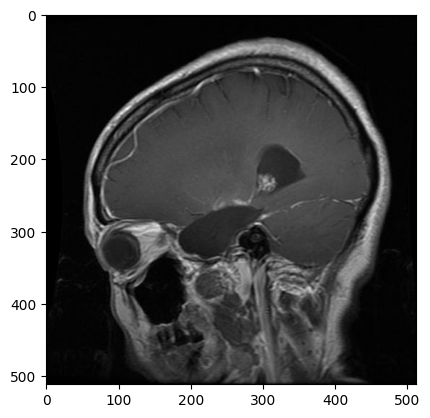

In [95]:
show_example(*dataset[3])


Label:  glioma_tumor (0)


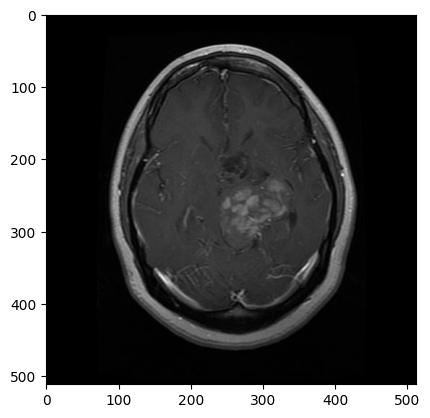

In [93]:
show_example(*dataset[0])

In [96]:
torch.manual_seed(42); # Seed is fixed

In [97]:
val_size = 250
train_size = len(dataset) - val_size
print(train_size)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

270


In [98]:
#Create dataloaders
from torch.utils.data.dataloader import DataLoader
batch_size = 50

In [99]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)

In [100]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break


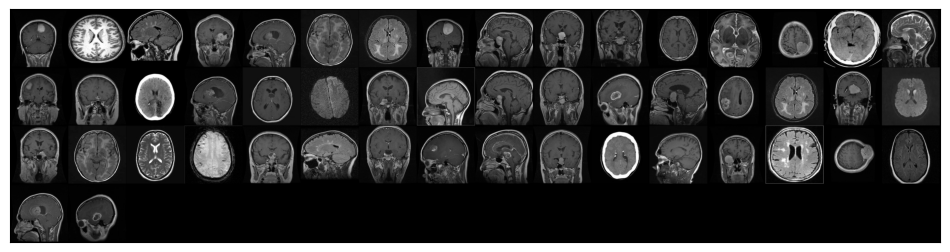

In [21]:
show_batch(train_dl)

In [101]:
import torch.nn as nn
import torch.nn.functional as F

In [102]:
class TumorCnnModel(nn.Module):

  def __init__(self):
    super(TumorCnnModel, self).__init__()

    self.nn = nn.Sequential(
        #input: 3 x 512 x 512 C, H, W , taiile de l'image
        nn.Conv2d(3, 32, kernel_size = 3, stride= 1),
        nn.ReLU(),  
        #output: 32 x 510 x 510

        nn.Conv2d(32, 32, kernel_size = 3, stride= 1),
        nn.ReLU(),
        #output 32 x 508 x 508

        nn.MaxPool2d(4,4), 
        #Output 32 x 127 x 127 )
       )
    
    self.fc = nn.Sequential(
            nn.Linear(32 * 127 * 127, 4)
        )

  def forward(self, x):
      out = self.nn(x)
      out = out.view(-1, 32*127*127)
      out = self.fc(out)
      out = torch.softmax(out, dim=1)
      return out

In [103]:
model = TumorCnnModel()
model

TumorCnnModel(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=516128, out_features=4, bias=True)
  )
)

In [104]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape', out.shape)
  print('out[0]', out[0])
  break

images.shape: torch.Size([50, 3, 512, 512])
out.shape torch.Size([50, 4])
out[0] tensor([0.2496, 0.2471, 0.2553, 0.2481], grad_fn=<SelectBackward0>)


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device' +str(device))

Using devicecpu


In [42]:
#Summary
from torchsummary import summary

CNN = TumorCnnModel() #Initialization
CNN.to(device = device)
summary(CNN, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 510, 510]             896
              ReLU-2         [-1, 32, 510, 510]               0
            Conv2d-3         [-1, 32, 508, 508]           9,248
              ReLU-4         [-1, 32, 508, 508]               0
         MaxPool2d-5         [-1, 32, 127, 127]               0
            Linear-6                    [-1, 4]       2,064,516
Total params: 2,074,660
Trainable params: 2,074,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 256.95
Params size (MB): 7.91
Estimated Total Size (MB): 267.86
----------------------------------------------------------------


In [64]:
def trainval(nepoch, train_loader, valid_loader, model, optimizer, criterion):

    training_losses = []
    valid_losses = []
    
    for epoch in range(nepoch):

        training_loss = 0
        valid_loss = 0

        #train the model
        model.train()
        for images, label in train_loader:
            images = images.to(device=device, dtype = torch.float32)
            label = label.to(device=device, dtype = torch.long)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * images.size(0)

        #Validate the model
        model.eval()
        for images, label in valid_loader:
            images = images.to(device=device, dtype = torch.float32)
            label = label.to(device=device, dtype = torch.long)
            with torch.no_grad():
                output = model(images)
                loss = criterion(output, label)
                valid_loss += loss.item() * images.size(0) 
        
        # calculate average loss over an epoch
        training_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        training_losses.append(training_loss)
        valid_losses.append(valid_loss)
    
        print(f'Epoch {epoch+1}: Training Loss : {training_loss:.6f}, Validation Loss : {valid_loss:.6f}')

    return training_losses, valid_losses



In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr = 0.01)
epochs = 20

train_losses_1, valid_losses_1 = trainval(epochs, train_dl, val_dl, CNN, optimizer, criterion)

Epoch 1: Training Loss : 1.329021, Validation Loss : 1.436464
Epoch 2: Training Loss : 1.268719, Validation Loss : 1.327501
Epoch 3: Training Loss : 1.231604, Validation Loss : 1.305368
Epoch 4: Training Loss : 1.203340, Validation Loss : 1.267891
Epoch 5: Training Loss : 1.138556, Validation Loss : 1.220160
Epoch 6: Training Loss : 1.133596, Validation Loss : 1.156583
Epoch 7: Training Loss : 1.090632, Validation Loss : 1.117799
Epoch 8: Training Loss : 1.090694, Validation Loss : 1.127228
Epoch 9: Training Loss : 1.011701, Validation Loss : 1.136352
Epoch 10: Training Loss : 1.119371, Validation Loss : 1.228012
Epoch 11: Training Loss : 1.021079, Validation Loss : 1.078563
Epoch 12: Training Loss : 1.028580, Validation Loss : 1.075736
Epoch 13: Training Loss : 0.975464, Validation Loss : 1.054257
Epoch 14: Training Loss : 0.912331, Validation Loss : 1.048239
Epoch 15: Training Loss : 0.896790, Validation Loss : 1.055341
Epoch 16: Training Loss : 0.885864, Validation Loss : 1.008198
E

Text(0, 0.5, 'loss value')

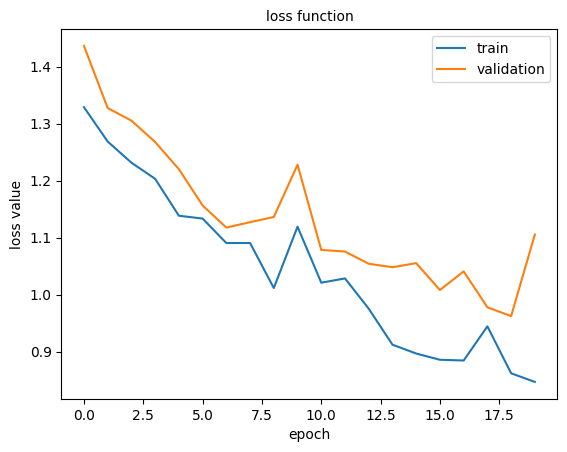

In [67]:
plt.plot(range(epochs), train_losses_1)
plt.plot(range(epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

Training and validation loss flectuate => Change hyperparameters ( lr or optimization algorithm (I can test Adam algo instead)).\
But I will test it anyway.

**Testing my model**

In [70]:
#dataset = torchvision.datasets.ImageFolder(root=data_dir + '/Training', transform=transform)
test_data = torchvision.datasets.ImageFolder(root=data_dir + '/Testing', transform=transform)
test_ld = DataLoader(test_data, batch_size)
print(test_data.classes)
print(test_ld)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [79]:
def evaluate_model(model, test_loader, criterion):
    test_loss = 0
    correct = 0
    total = 0

    model.eval()  # Intialize evaluation

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device=device, dtype=torch.float32), labels.to(device=device, dtype=torch.long)
            outputs = model(data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * data.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct / total

    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: {:.2f}% ({}/{})'.format(test_accuracy, correct, total))

    return test_loss, test_accuracy


In [80]:
evaluate_model(model, test_ld, criterion)

Test Loss: 1.385039
Test Accuracy: 0.30% (117/394)


(1.3850394638661805, 0.2969543147208122)